To detect negative speech in tweets.

## Dataset : 
The data set contains tweets and sentiment related to it. Here we need to predict the sentiment for a given tweet.
Here, in label 
* __label “0”: Positive Sentiment__ 
* __label “1”: Negative Sentiment__  

## Step 1 : Import libraries

Here we are gonna use NLTK, i.e., Natural Language Tool Kit
As name suggests, it is contains all the modules required for NLP operations.
In this problem, as we are dealing with statements, NLTK suits well.

In [75]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.pipeline import make_pipeline
import warnings 
warnings.filterwarnings("ignore")
import pickle

## Step 2: Import datasets

Read the data with pandas.
* __train.csv__ : It contains tweets with its corresponding sentiment. We'll use this to train our model to predict the sentiment behind the tweet.

* __test.csv__ : It contains the data we are gonna use to test our model.


In [76]:
train  = pd.read_csv("twitter-sentiment-analysis/train.csv")
test = pd.read_csv("twitter-sentiment-analysis/test.csv")
train.head()

,id,label,tweet
957,958,0,â #eur/gbp subdued trading action around 0....
19314,19315,0,preston up next #pirelli #ormsuk #britishmx


In [77]:
train.shape, test.shape

((31962, 3), (17197, 2))

## Step 3 : Data cleaning and Preprocessing

Remove twitter handlers i.e., @user

In [78]:
train['cleaned_tweet'] = train.tweet.apply(lambda x: ' '.join([word for word in x.split() if not word.startswith('@')]))
test['cleaned_tweet'] = test.tweet.apply(lambda x: ' '.join([word for word in x.split() if not word.startswith('@')]))

### Hashtags
Graph to show normal tweets. Check top 20 most used hashtags and plot them according to their frequency

In [79]:
#Select all words from normal tweet
normal_words = ' '.join([word for word in train['cleaned_tweet'][train['label'] == 0]])
#Collect all hashtags
pos_htag = [htag for htag in normal_words.split() if htag.startswith('#')]
#Remove hashtag symbol (#)
pos_htag = [pos_htag[i][1:] for i in range(len(pos_htag))]
#Count frequency of each word
pos_htag_freqcount = nltk.FreqDist(pos_htag)
pos_htag_df = pd.DataFrame({'Hashtag' : list(pos_htag_freqcount.keys()),
                            'Count' : list(pos_htag_freqcount.values())})

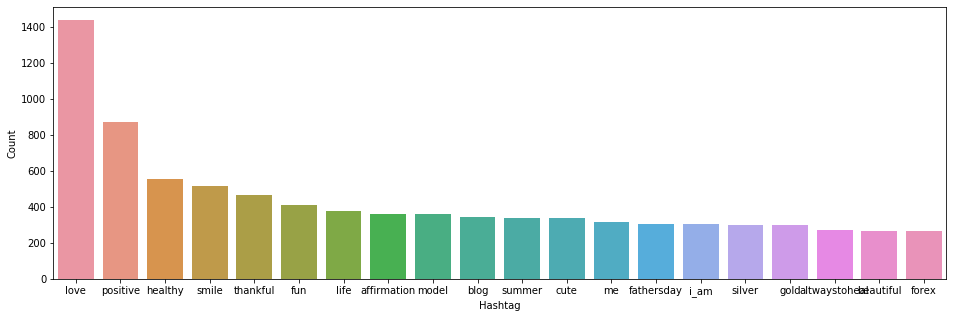

In [80]:
#Select top 20 most frequent hashtags and plot them   
most_frequent = pos_htag_df.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=most_frequent, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

Graph to show negative tweets. In negative tweets, 20 hashtags that appeared the most is shown in graph.

In [81]:
#Repeat same steps for negative tweets
negative_words = ' '.join([word for word in train['cleaned_tweet'][train['label'] == 1]])
neg_htag = [htag for htag in negative_words.split() if htag.startswith('#')]
neg_htag = [neg_htag[i][1:] for i in range(len(neg_htag))]
neg_htag_freqcount = nltk.FreqDist(neg_htag)
neg_htag_df = pd.DataFrame({'Hashtag' : list(neg_htag_freqcount.keys()),
                            'Count' : list(neg_htag_freqcount.values())})

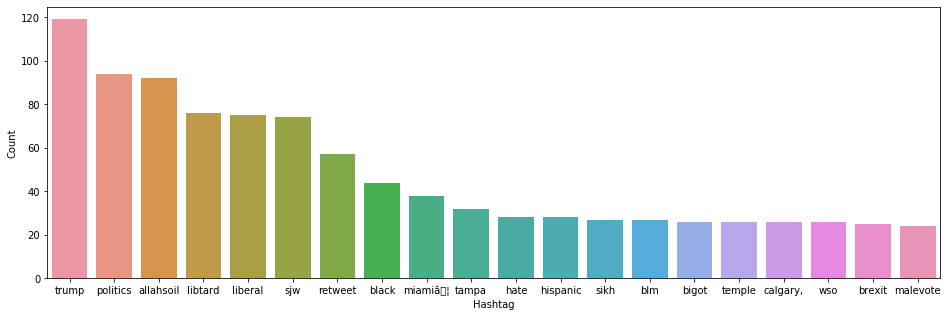

In [82]:
most_frequent = neg_htag_df.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=most_frequent, x= "Hashtag", y = "Count")
plt.show()

From both plots, we can conclude that hashtags are very important for sentiment analysis and should not be ignored.

Words used like love, friend, happy are used in normal tweets whereas negative can be found in words like trump, black, politics etc.

In [83]:
train.head(2)

,id,label,tweet,cleaned_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...


In [84]:
X_train, X_val, y_train, y_val = train_test_split(train['cleaned_tweet'], train['label'], random_state = 0)
X_train.shape, X_val.shape

((23971,), (7991,))

## Applying Bag-of-Words

Rescale data using CountVectorizer
# __CountVectorizer__
It’ll see the unique words in the complete para or content given to it and then does one hot encoding accordingly. CountVectorization generates a sparse matrix representing all the words in the document. 

In [85]:
cv = CountVectorizer()
vect = cv.fit(X_train)
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [86]:
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

<23971x34478 sparse matrix of type '<class 'numpy.int64'>'
	with 266363 stored elements in Compressed Sparse Row format>

### Naive Bayes

In [87]:
naive_base_model = MultinomialNB()
naive_base_model.fit(X_train_vectorized, y_train)
pred = naive_base_model.predict(vect.transform(X_val))
print('F1 :', f1_score(y_val, pred))

F1 : 0.5725288831835686


### Logistic Regression

In [88]:
logistic_model_cv = LogisticRegression()
logistic_model_cv.fit(X_train_vectorized, y_train)
pred = logistic_model_cv.predict(vect.transform(X_val))
print('F1 :', f1_score(y_val, pred))

F1 : 0.6473317865429236


Logistic Regression performed well then Naive Bayes for the default parameters. Thus, we will be using only Logistic Regression ahead.

# __Tfidf__
 This one is similar to countvectorizer, however it removes the stopwords and stores the important words which might be used less but gives us more better features.And stores the frequency of the words.

In [89]:
# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
vect = TfidfVectorizer().fit(X_train)
print('Total Features =', len(vect.get_feature_names()))
X_train_vectorized = vect.transform(X_train)

Total Features = 34478


### Naive Bayes

In [90]:
naive_base_model = MultinomialNB()
naive_base_model.fit(X_train_vectorized, y_train)
pred = naive_base_model.predict(vect.transform(X_val))
print('F1 :', f1_score(y_val, pred))

F1 : 0.18771331058020477


### Logistic Regression

In [91]:
logistic_model_tf = LogisticRegression()
logistic_model_tf.fit(X_train_vectorized, y_train)
pred = logistic_model_tf.predict(vect.transform(X_val))
print('F1: ', f1_score(y_val, pred))

F1:  0.41907514450867056


tf-idf not performed well for this data.

## Save the model in pickle file

As logistic_model_cv gave us highest accuracy we'll go with it and save it to pickle file.
We save our model to pickle file so that when we want to perform predictions on unseen data, we don't have to train our model again. Any object in python can be pickled so that it can be saved on disk. What pickle does is that it “serialises” the object first before writing it to file. Pickling is a way to convert a python object (list, dict, etc.) into a character stream.  

In [92]:
with open('model.pkl','wb') as file:
    pickle.dump(cv, file)
    pickle.dump(logistic_model_cv, file)

In [93]:
pred

array([0, 0, 0, ..., 0, 0, 0])